## Code used to train the $r$ band model



In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
import pyarrow
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight
import random



In [2]:
input_file = '../training_set/features_ZTF_PS1_catwise/features_labeled_set_PS1_score_ZTF_rband_unique_catwise.parquet'

filterid = 2


if filterid==1: band='g'
if filterid==2: band='r'


features_list_4model = 'models/optimal_hierarchical_features_'+band+'band_zsep'
model_init_layer = 'models/hierarchical_model_init_level_'+band+'band_zsep'
model_variable_layer = 'models/hierarchical_model_var_level_'+band+'band_zsep'
model_periodic_layer = 'models/hierarchical_model_periodic_level_'+band+'band_zsep'
model_stochastic_layer = 'models/hierarchical_model_stochastic_level_'+band+'band_zsep'
model_transient_layer = 'models/hierarchical_model_transient_level_'+band+'band_zsep'

In [3]:
#for reproducibility 
random.seed(10)
print(random.random())

0.5714025946899135


In [4]:
df_feat = pd.read_parquet(input_file)
df_feat = df_feat[(df_feat.filterid==filterid) & (df_feat.Mean<=20.5)]
#df_feat['objectid'] = df_feat['objectid'].astype('int32')
#df_feat.rename({"oid_alerce": "oid"}, axis="columns", inplace = True)
df_feat.set_index('source_id',inplace=True)

df_feat.replace([np.inf, -np.inf], np.nan, inplace=True)




print(df_feat)

                                  ra        dec source_period source_class  \
source_id                                                                    
SDSS J235959.94+204315.8  359.999746  20.721087          None            Q   
SDSS J235959.90+031606.9  359.999633   3.268621          None            Q   
CALIBSTARS_0667340        359.999499  -0.221595          None   CALIBSTARS   
SDSS J235959.83+344315.0  359.999293  34.720858          None            Q   
CALIBSTARS_0665125        359.999198  -0.815534          None   CALIBSTARS   
...                              ...        ...           ...          ...   
UVQSJ000000.15-200427.7     0.000657 -20.074344          None            A   
CALIBSTARS_0667685          0.000643   0.809790          None   CALIBSTARS   
SDSS J000000.15+353104.2    0.000629  35.517844          None            Q   
CALIBSTARS_0668079          0.000273  -1.034291          None   CALIBSTARS   
CALIBSTARS_0665126          0.000210  -0.838722          None   

In [5]:
df_feat.columns.values #feauture Multiband_period is in fact single band

array(['ra', 'dec', 'source_period', 'source_class', 'classALeRCE',
       'source_cat', 'source_redshift', 'objectid', 'filterid', 'objra',
       'objdec', 'nepochs', 'gal_b', 'gal_l', 'MHPS_ratio', 'MHPS_low',
       'MHPS_high', 'MHPS_non_zero', 'MHPS_PN_flag', 'SPM_A', 'SPM_t0',
       'SPM_gamma', 'SPM_beta', 'SPM_tau_rise', 'SPM_tau_fall', 'SPM_chi',
       'SPM_C', 'Amplitude', 'AndersonDarling', 'Autocor_length',
       'Beyond1Std', 'Con', 'Eta_e', 'Gskew', 'MaxSlope', 'Mean',
       'Meanvariance', 'MedianAbsDev', 'MedianBRP', 'PairSlopeTrend',
       'PercentAmplitude', 'Q31', 'Rcs', 'Skew', 'SmallKurtosis', 'Std',
       'StetsonK', 'Pvar', 'ExcessVar', 'SF_ML_amplitude', 'SF_ML_gamma',
       'IAR_phi', 'LinearTrend', 'GP_DRW_sigma', 'GP_DRW_tau',
       'Multiband_period', 'PPE', 'Power_rate_1/4', 'Power_rate_1/3',
       'Power_rate_1/2', 'Power_rate_2', 'Power_rate_3', 'Power_rate_4',
       'Psi_CS', 'Psi_eta', 'Harmonics_mag_1', 'Harmonics_mag_2',
       'Harmonics_m

In [6]:
df_labels = df_feat[['classALeRCE','source_class', 'objra','objdec','source_redshift']]

#keeping only BL Lacs for the blazar class
df_labels = df_labels[(df_labels['source_class']!="QSO RLoud flat radio sp.") & (df_labels['source_class']!="Blazar Uncertain type") &  (df_labels['source_class']!="BL Lac-galaxy dominated")]

df_labels = df_labels[['classALeRCE', 'objra','objdec','source_redshift']]

#df_labels.set_index('objectid',inplace=True)
df_labels.head()

,classALeRCE,objra,objdec,source_redshift
source_id,,,,
SDSS J235959.94+204315.8,QSO,359.999756,20.721125,2.010
SDSS J235959.90+031606.9,QSO,359.999634,3.268655,1.233
CALIBSTARS_0667340,nonvar-star,359.999542,-0.221592,NaN
SDSS J235959.83+344315.0,QSO,359.999298,34.720860,3.109
CALIBSTARS_0665125,nonvar-star,359.999207,-0.815569,NaN


In [7]:
print(df_feat.index)

Index(['SDSS J235959.94+204315.8', 'SDSS J235959.90+031606.9',
       'CALIBSTARS_0667340', 'SDSS J235959.83+344315.0', 'CALIBSTARS_0665125',
       'SDSS J235959.66+170547.8', 'LAMOSTJ235959.60+172344.4',
       'CALIBSTARS_0667339', 'SDSS J235959.44+103350.6',
       'SDSS J235959.44+000841.5',
       ...
       'CALIBSTARS_0665575', 'CALIBSTARS_0668061', 'SDSS J000000.47-002703.9',
       'SDSS J000000.45+092308.2', 'CALIBSTARS_0667665',
       'UVQSJ000000.15-200427.7', 'CALIBSTARS_0667685',
       'SDSS J000000.15+353104.2', 'CALIBSTARS_0668079', 'CALIBSTARS_0665126'],
      dtype='object', name='source_id', length=936212)


In [8]:
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SN-other'
df_labels.loc[(df_labels['class_original'] == 'SNII'), 'class_original'] = 'SN-other'
df_labels.loc[(df_labels['class_original'] == 'SNIbc'), 'class_original'] = 'SN-other'
df_labels.loc[(df_labels['class_original'] == 'SLSN'), 'class_original'] = 'SN-other'
df_labels.loc[(df_labels['class_original'] == 'Ceph'), 'class_original'] = 'CEP'#new name for paper
df_labels.loc[(df_labels['class_original'] == 'NLAGN'), 'class_original'] = 'nonvar-galaxy'#'typeII-AGN' #new name for paper
df_labels.loc[(df_labels['class_original'] == 'NLQSO'), 'class_original'] = 'nonvar-galaxy'#'typeII-AGN'#new name for paper
df_labels.loc[((df_labels['class_original'] == 'QSO') | (df_labels['class_original'] == 'AGN')) & (df_labels['source_redshift']<0.5) , 'class_original'] = 'lowz-AGN'
df_labels.loc[((df_labels['class_original'] == 'QSO') | (df_labels['class_original'] == 'AGN')) & ((df_labels['source_redshift']>=0.5) & (df_labels['source_redshift']<3.0)) , 'class_original'] = 'midz-AGN'
df_labels.loc[((df_labels['class_original'] == 'QSO') | (df_labels['class_original'] == 'AGN')) & (df_labels['source_redshift']>=3.0) , 'class_original'] = 'highz-AGN'


df_labels.loc[(df_labels['class_original'] == 'RSCVn'), 'class_original'] = 'Periodic-Other'
df_labels.loc[(df_labels['class_original'] == 'Periodic-Other'), 'class_original'] = 'Periodic-other'


#df_labels.loc[(df_labels['source_class'] == '7') & (df_labels['source_cat'] == 'CRTSsouth'), 'class_original'] = 'Rotational'

print(df_labels)



label_order = ['SNIa','SN-other','CV/Nova','lowz-AGN','midz-AGN', 'highz-AGN', 'Blazar', 'YSO',
               'LPV', 'EA', 'EB/EW', 'DSCT', 'RRL', 'CEP', 'Periodic-other',
               'nonvar-galaxy','nonvar-star']# 'Rotational','typeII-AGN','nonvar-galaxy','nonvar-star']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]


#defining init classes:

labels['class_init'] = 'variable'

labels.loc[(labels['class_original'] == 'nonvar-galaxy') , 'class_init'] = 'nonvar-galaxy'
labels.loc[(labels['class_original'] == 'nonvar-star') , 'class_init'] = 'nonvar-star'

cm_classes_init = ['variable','nonvar-galaxy', 'nonvar-star']

#defining variable classes:

labels['class_variable'] = labels['class_original']

labels.loc[ (labels['class_variable'] == 'LPV') | (labels['class_variable'] == 'Periodic-other') | (labels['class_variable'] == 'EA') | (labels['class_variable'] == 'EB/EW')  | (labels['class_variable'] == 'DSCT') | (labels['class_variable'] == 'RRL') | (labels['class_variable'] == 'CEP') , 'class_variable'] = 'Periodic'

labels.loc[(labels['class_variable'] == 'CV/Nova') | (labels['class_variable'] == 'SNIa') | (labels['class_variable'] == 'SN-other'), 'class_variable'] = 'Transient'

labels.loc[ (labels['class_variable'] == 'YSO') |     (labels['class_variable'] == 'lowz-AGN') |  (labels['class_variable'] == 'midz-AGN') |     (labels['class_variable'] == 'highz-AGN') | (labels['class_variable'] == 'Blazar')  , 'class_variable'] = 'Stochastic'

cm_classes_variable = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

cm_classes_periodic = ['LPV', 'EA', 'EB/EW', 'DSCT', 'RRL', 'CEP','Periodic-other']
cm_classes_stochastic = ['lowz-AGN','midz-AGN', 'highz-AGN', 'Blazar', 'YSO']
cm_classes_transient = ['SNIa','SN-other','CV/Nova']

print(labels['class_variable'].values.shape)
labels.head()

                          classALeRCE       objra     objdec  source_redshift  \
source_id                                                                       
SDSS J235959.94+204315.8          QSO  359.999756  20.721125            2.010   
SDSS J235959.90+031606.9          QSO  359.999634   3.268655            1.233   
CALIBSTARS_0667340        nonvar-star  359.999542  -0.221592              NaN   
SDSS J235959.83+344315.0          QSO  359.999298  34.720860            3.109   
CALIBSTARS_0665125        nonvar-star  359.999207  -0.815569              NaN   
...                               ...         ...        ...              ...   
UVQSJ000000.15-200427.7           AGN    0.000643 -20.074320            0.291   
CALIBSTARS_0667685        nonvar-star    0.000638   0.809758              NaN   
SDSS J000000.15+353104.2          QSO    0.000608  35.517868            0.845   
CALIBSTARS_0668079        nonvar-star    0.000298  -1.034310              NaN   
CALIBSTARS_0665126        no

,class_original,class_init,class_variable
source_id,,,
SDSS J235959.94+204315.8,midz-AGN,variable,Stochastic
SDSS J235959.90+031606.9,midz-AGN,variable,Stochastic
CALIBSTARS_0667340,nonvar-star,nonvar-star,nonvar-star
SDSS J235959.83+344315.0,highz-AGN,variable,Stochastic
CALIBSTARS_0665125,nonvar-star,nonvar-star,nonvar-star


In [9]:
#defining columns excluded from the df_nd table


rm_nd_cols = [
'objectid',   
'filterid', 
'classALeRCE', 
'ra', 
'dec',
'source_period',
'source_class',
'source_cat', 
'source_redshift',
'classALeRCE',
'objra', 
'objdec',
'nepochs',
'MHPS_non_zero', 
'MHPS_PN_flag',
'filterid', 
'SPM_C',
'gal_b',
'gal_l',
'objID',
'gmag',
'e_gmag',
'rmag',
'e_rmag',
'imag',
'e_imag',
'W1mproPM',
'W2mproPM',
#'Mean',
]








df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')

#print(df['g-r_max'].values.size)

#print(df['g-r_max'].values.size)
df_train = df.copy()
#df_train = df_train.fillna(-999)
labels = df[['class_original','class_init','class_variable']]
df.drop(['Mean','class_original','class_init','class_variable'], axis=1, inplace=True)

df = df.astype('float32', copy=False)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(-999)

print(len(labels['class_original'].values))

#print(df['g-r_max'].values.size)
df.head()

936033


,MHPS_ratio,MHPS_low,MHPS_high,SPM_A,SPM_t0,SPM_gamma,SPM_beta,SPM_tau_rise,SPM_tau_fall,SPM_chi,...,ps_score,gps1-rps1,rps1-ips1,gps1-W1,gps1-W2,rps1-W1,rps1-W2,ips1-W1,ips1-W2,W1-W2
source_id,,,,,,,,,,,,,,,,,,,,,
1001004003261,4.816600,0.089553,0.018593,0.664702,408.660889,1.000000,0.701687,2.095816,15.076224,0.134886,...,0.999167,1.0950,0.5186,4.0759,4.0899,2.9809,2.9949,2.4623,2.4763,0.014000
1001004003617,8.752442,0.570906,0.065228,12.832290,440.675934,1.000000,0.672354,1.000000,59.606400,5.599725,...,0.962500,0.2396,-0.4483,2.8523,2.8253,2.6127,2.5857,3.0610,3.0340,-0.026999
1001004005410,7.244754,0.008740,0.001206,0.118208,668.160706,50.319221,0.297529,99.841698,3.222554,0.135011,...,0.968042,0.3293,0.1215,1.9549,1.9119,1.6256,1.5826,1.5041,1.4611,-0.042999
1001004005734,1.779061,0.029847,0.016777,12.467240,399.191681,1.284897,0.802344,1.000000,34.002945,3.058435,...,0.987500,0.4791,0.1860,2.1941,2.1681,1.7150,1.6890,1.5290,1.5030,-0.026000
1001004022706,1961.227905,8.631114,0.004401,1.245707,471.769409,1.010033,0.135897,6.749021,10.366745,0.363156,...,0.991935,0.3623,1.2179,4.2885,4.5735,3.9262,4.2112,2.7083,2.9933,0.285000


In [10]:
#print(df.columns)
print(np.array(df.columns))
print(len(np.array(df.columns)))

['MHPS_ratio' 'MHPS_low' 'MHPS_high' 'SPM_A' 'SPM_t0' 'SPM_gamma'
 'SPM_beta' 'SPM_tau_rise' 'SPM_tau_fall' 'SPM_chi' 'Amplitude'
 'AndersonDarling' 'Autocor_length' 'Beyond1Std' 'Con' 'Eta_e' 'Gskew'
 'MaxSlope' 'Meanvariance' 'MedianAbsDev' 'MedianBRP' 'PairSlopeTrend'
 'PercentAmplitude' 'Q31' 'Rcs' 'Skew' 'SmallKurtosis' 'Std' 'StetsonK'
 'Pvar' 'ExcessVar' 'SF_ML_amplitude' 'SF_ML_gamma' 'IAR_phi'
 'LinearTrend' 'GP_DRW_sigma' 'GP_DRW_tau' 'Multiband_period' 'PPE'
 'Power_rate_1/4' 'Power_rate_1/3' 'Power_rate_1/2' 'Power_rate_2'
 'Power_rate_3' 'Power_rate_4' 'Psi_CS' 'Psi_eta' 'Harmonics_mag_1'
 'Harmonics_mag_2' 'Harmonics_mag_3' 'Harmonics_mag_4' 'Harmonics_mag_5'
 'Harmonics_mag_6' 'Harmonics_mag_7' 'Harmonics_phase_2'
 'Harmonics_phase_3' 'Harmonics_phase_4' 'Harmonics_phase_5'
 'Harmonics_phase_6' 'Harmonics_phase_7' 'Harmonics_mse' 'ps_score'
 'gps1-rps1' 'rps1-ips1' 'gps1-W1' 'gps1-W2' 'rps1-W1' 'rps1-W2' 'ips1-W1'
 'ips1-W2' 'W1-W2']
71


In [11]:
for idx, cl in enumerate(cm_classes_original):
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

SNIa 1931
SN-other 932
CV/Nova 2208
lowz-AGN 33540
midz-AGN 279600
highz-AGN 15743
Blazar 1612
YSO 13221
LPV 34715
EA 7401
EB/EW 31706
DSCT 900
RRL 32527
CEP 540
Periodic-other 1710
nonvar-galaxy 102178
nonvar-star 375569


  ### Defining functions to plot the confusion matrix and the feature importance

In [12]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm[np.isnan(cm)] = 0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 23)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 22)
    plt.xlabel('Predicted label',fontsize = 22)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
def plot_confusion_matrix_all(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm[np.isnan(cm)] = 0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    


def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    for i in I[0:30]:
        print(feature_names[i], "& %.3f" % (model.feature_importances_[i]))
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name, bbox_inches='tight')
    #plt.close()

### Pre-processing training data


In [13]:
Y_bottom = labels['class_original']
Y_variable = labels['class_variable']
Y_init = labels['class_init']

print(len(labels['class_init'].values))
X_init = df.astype('float32', copy=True)

#splitting training set
X_train_init, X_test_init, y_train_bottom, y_test_bottom, y_train_variable, y_test_variable, y_train_init, y_test_init  = model_selection.train_test_split(X_init,
       Y_bottom, Y_variable, Y_init, test_size=0.2, stratify=Y_bottom)


#first level (var) has all the sources

#second level (variable) has only variable classes

X_train_variable = X_train_init.loc[y_train_init=='variable', :]
y_train_variable = y_train_variable.loc[y_train_init=='variable']

y_train_bottom = y_train_bottom.loc[y_train_init=='variable']



#third level (bottom) has only variable classes

X_train_periodic = X_train_variable.loc[y_train_variable=='Periodic', :]
y_train_periodic = y_train_bottom.loc[y_train_variable=='Periodic']

X_train_stochastic = X_train_variable.loc[y_train_variable=='Stochastic', :]
y_train_stochastic = y_train_bottom.loc[y_train_variable=='Stochastic']

X_train_transient = X_train_variable.loc[y_train_variable=='Transient', :]
y_train_transient = y_train_bottom.loc[y_train_variable=='Transient']

#the test set will be defined as the sources are classified



print(X_train_init.dtypes)

936033
MHPS_ratio    float32
MHPS_low      float32
MHPS_high     float32
SPM_A         float32
SPM_t0        float32
               ...   
rps1-W1       float32
rps1-W2       float32
ips1-W1       float32
ips1-W2       float32
W1-W2         float32
Length: 71, dtype: object


In [14]:
print(y_train_init)

source_id
CALIBSTARS_0616568             nonvar-star
5603716912628035584          nonvar-galaxy
CALIBSTARS_0406321             nonvar-star
CALIBSTARS_0571147             nonvar-star
LAMOSTJ021248.87+432501.2         variable
                                 ...      
CALIBSTARS_0187568             nonvar-star
7529028302628646912          nonvar-galaxy
SDSS J001129.79+061810.5          variable
6768790569268382720               variable
SDSS J130922.64+310851.8          variable
Name: class_init, Length: 748826, dtype: object


In [15]:
#Training first layer of the RF model

rf_model_init = RandomForestClassifier(
            n_estimators=300,
            max_features=0.4,
            max_depth=70,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1
            )


rf_model_init.fit(X_train_init.values, y_train_init)

#testing first layer performance

y_true, y_pred = y_test_init, rf_model_init.predict(X_test_init)
y_pred_proba_init = rf_model_init.predict_proba(X_test_init)

classes_order_proba_init = rf_model_init.classes_
print(classes_order_proba_init)


print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_init = list(X_train_init)
        
with open(model_init_layer, 'wb') as f:
            pickle.dump(
                rf_model_init,
                f,
                pickle.HIGHEST_PROTOCOL)

/Users/psanchez/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but BalancedRandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/psanchez/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but BalancedRandomForestClassifier was fitted without feature names
  warnings.warn(


['nonvar-galaxy' 'nonvar-star' 'variable']
Accuracy: 0.9759624373020239
Balanced accuracy: 0.9805696212085819


In [16]:
with open(features_list_4model, 'wb') as f:
            pickle.dump(
                features_init,
                f,
                pickle.HIGHEST_PROTOCOL)

[[87589  3304   764]
 [  219 20207    10]
 [  166    37 74911]]
Normalized confusion matrix
[[ 96.   4.   1.]
 [  1.  99.   0.]
 [  0.   0. 100.]]


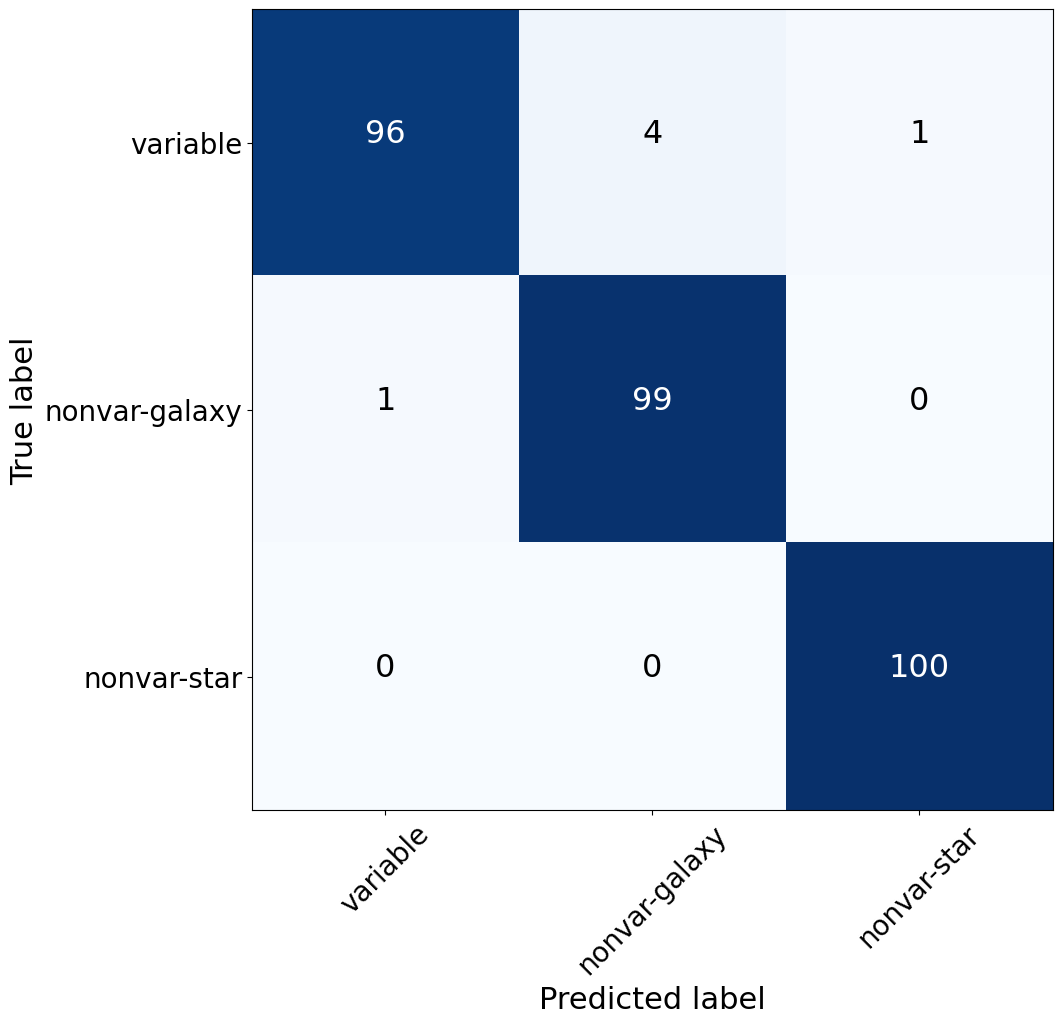

In [17]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_init)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_init,'plots/training_conf_matrix_init_level_'+band+'band_zsep.pdf')

ps_score & 0.313
ips1-W2 & 0.149
ips1-W1 & 0.066
GP_DRW_sigma & 0.059
W1-W2 & 0.057
PPE & 0.033
Psi_eta & 0.031
Q31 & 0.028
rps1-W2 & 0.026
Harmonics_mag_1 & 0.020
gps1-rps1 & 0.020
Meanvariance & 0.017
GP_DRW_tau & 0.017
SPM_chi & 0.016
Eta_e & 0.016
MedianAbsDev & 0.015
Autocor_length & 0.013
gps1-W1 & 0.012
rps1-ips1 & 0.011
Std & 0.007
ExcessVar & 0.006
gps1-W2 & 0.005
Rcs & 0.005
rps1-W1 & 0.004
IAR_phi & 0.004
SPM_A & 0.003
Psi_CS & 0.002
Amplitude & 0.002
Gskew & 0.002
Skew & 0.002


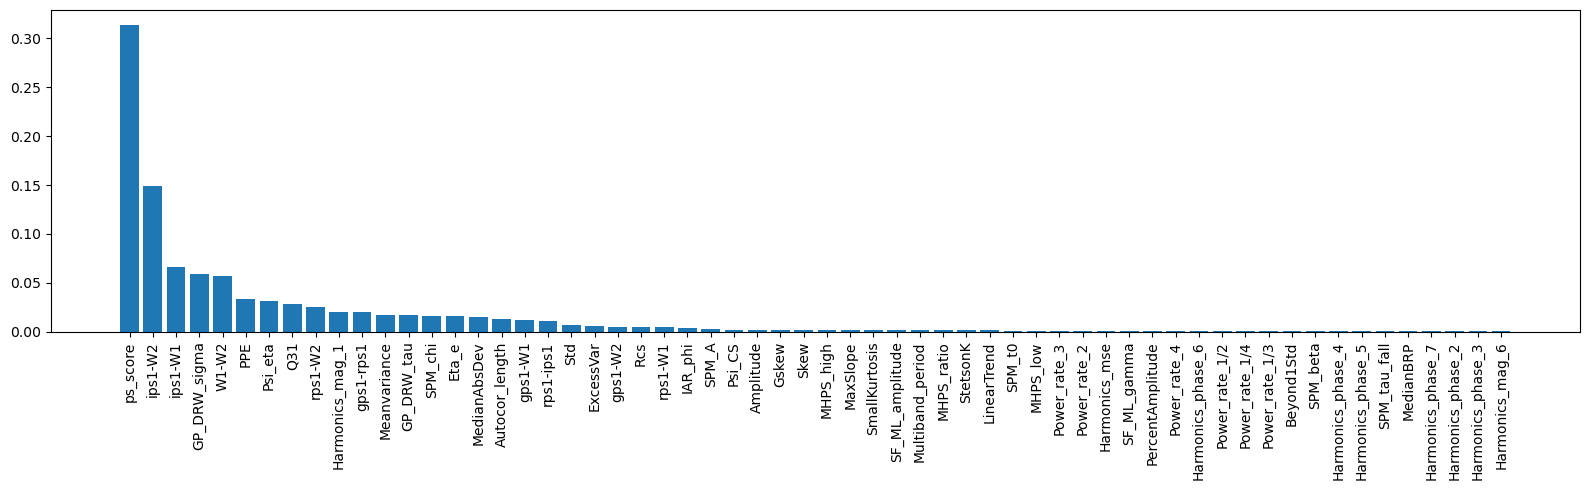

In [18]:
#plotting feature importance
plot_feature_importances(rf_model_init, features_init, 'plots/training_feature_ranking_init_level_'+band+'band_zsep.pdf')

Counter({'Stochastic': 65255, 'Periodic': 21642, 'Transient': 692, 'nonvar-galaxy': 219, 'nonvar-star': 166})


Text(0.5, 1.0, 'sources classified as variable')

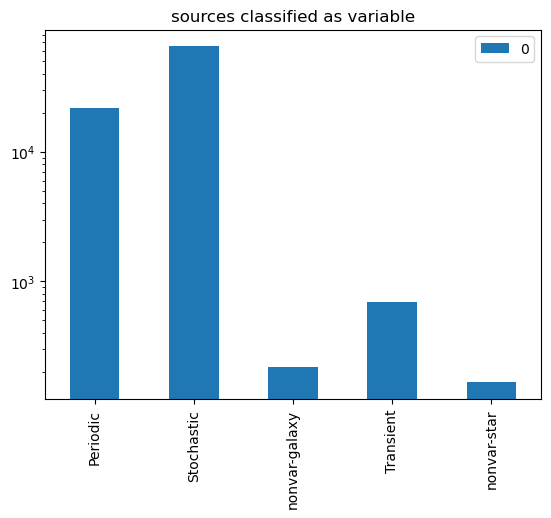

In [19]:
# separating classes (according to the predicted classification):

y_test_variable = y_test_variable.loc[y_pred=='variable']
X_test_variable =  X_test_init.loc[y_pred=='variable',:]

y_test_bottom_init = y_test_bottom.loc[y_pred=='variable']
X_test_bottom_init =  X_test_init.loc[y_pred=='variable',:]

letter_counts = Counter(y_test_variable)
print(letter_counts)


df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.yscale('log')
plt.title('sources classified as variable')

Counter({'nonvar-galaxy': 20207, 'lowz-AGN': 2440, 'midz-AGN': 348, 'SNIa': 214, 'SN-other': 94, 'Blazar': 87, 'YSO': 55, 'nonvar-star': 37, 'RRL': 33, 'highz-AGN': 25, 'CV/Nova': 4, 'EB/EW': 2, 'LPV': 1, 'Periodic-other': 1})


Text(0.5, 1.0, 'sources classified as nonvar-galaxy')

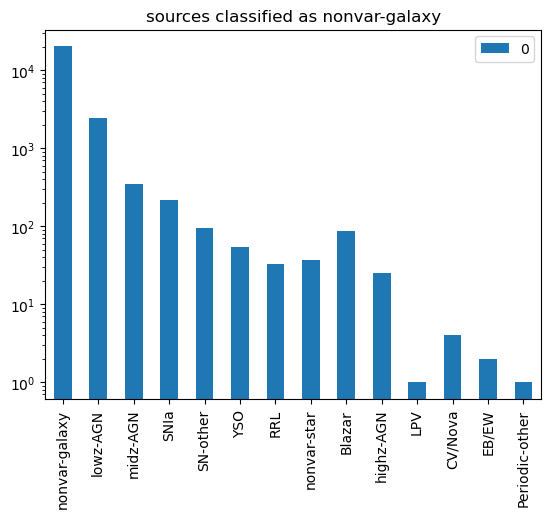

In [20]:

y_test_galaxy = y_test_bottom.loc[y_pred=='nonvar-galaxy']
X_test_galaxy = X_test_init.loc[y_pred=='nonvar-galaxy',:]

letter_counts = Counter(y_test_galaxy)
print(letter_counts)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.yscale('log')
plt.title('sources classified as nonvar-galaxy')

Counter({'nonvar-star': 74911, 'YSO': 372, 'midz-AGN': 116, 'RRL': 76, 'EB/EW': 64, 'EA': 36, 'highz-AGN': 32, 'Periodic-other': 21, 'DSCT': 16, 'nonvar-galaxy': 10, 'lowz-AGN': 10, 'CV/Nova': 9, 'LPV': 8, 'Blazar': 3, 'SNIa': 1})


Text(0.5, 1.0, 'sources classified as nonvar-star')

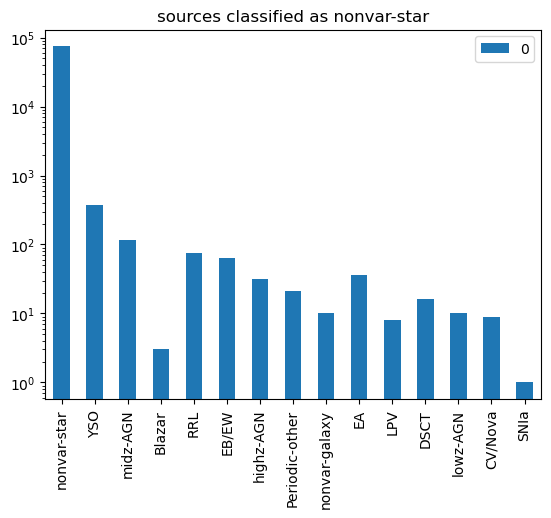

In [21]:
y_test_star = y_test_bottom.loc[y_pred=='nonvar-star']
X_test_star = X_test_init.loc[y_pred=='nonvar-star',:]

letter_counts = Counter(y_test_star)
print(letter_counts)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.yscale('log')
plt.title('sources classified as nonvar-star')

 ### Variable level

In [22]:
#Training variable level

rf_model_variable = RandomForestClassifier(
            n_estimators=500,
            max_features=0.4,
            max_depth=70,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_variable.fit(X_train_variable, y_train_variable)


#testing variable layer performance

y_true_variable, y_pred_variable = y_test_variable, rf_model_variable.predict(X_test_variable)

y_pred_proba_variable = rf_model_variable.predict_proba(X_test_variable)

print("Accuracy:", metrics.accuracy_score(y_true_variable, y_pred_variable))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true_variable, y_pred_variable))

classes_order_proba_variable = rf_model_variable.classes_
print(classes_order_proba_variable)


#Dumping trained model

features_variable = list(X_train_variable)

with open(model_variable_layer, 'wb') as f:
            pickle.dump(
                rf_model_variable,
                f,
                pickle.HIGHEST_PROTOCOL)

Accuracy: 0.9829495078091254
Balanced accuracy: 0.5887969970422955
['Periodic' 'Stochastic' 'Transient']


[[  670     8    14]
 [  386 64404   465]
 [  176    66 21400]]
Normalized confusion matrix
[[97.  1.  2.]
 [ 1. 99.  1.]
 [ 1.  0. 99.]]


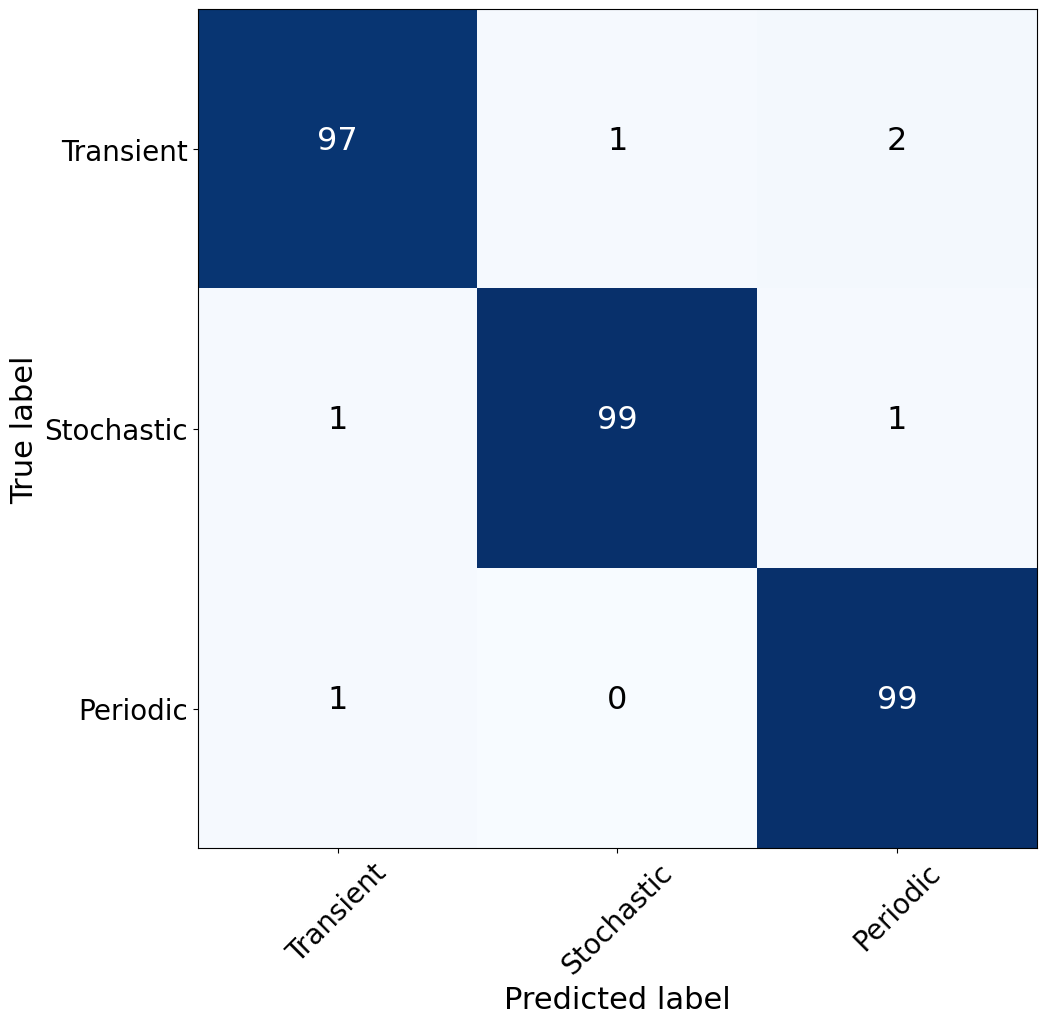

In [23]:
#plotting confusion matrix

cnf_matrix = metrics.confusion_matrix(y_true_variable, y_pred_variable, labels=cm_classes_variable)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_variable,'plots/training_conf_matrix_variable_level_'+band+'band_zsep.pdf')

W1-W2 & 0.242
SPM_chi & 0.116
Psi_eta & 0.094
Eta_e & 0.049
Harmonics_mse & 0.040
ips1-W2 & 0.038
SPM_A & 0.038
ps_score & 0.030
gps1-W2 & 0.026
gps1-W1 & 0.024
rps1-W2 & 0.023
gps1-rps1 & 0.023
Amplitude & 0.021
rps1-ips1 & 0.021
IAR_phi & 0.018
PPE & 0.014
Psi_CS & 0.013
GP_DRW_tau & 0.010
rps1-W1 & 0.009
Std & 0.008
MHPS_low & 0.008
MHPS_high & 0.008
MHPS_ratio & 0.007
ips1-W1 & 0.007
ExcessVar & 0.007
Harmonics_mag_7 & 0.007
PercentAmplitude & 0.006
GP_DRW_sigma & 0.005
Skew & 0.004
Harmonics_mag_6 & 0.004


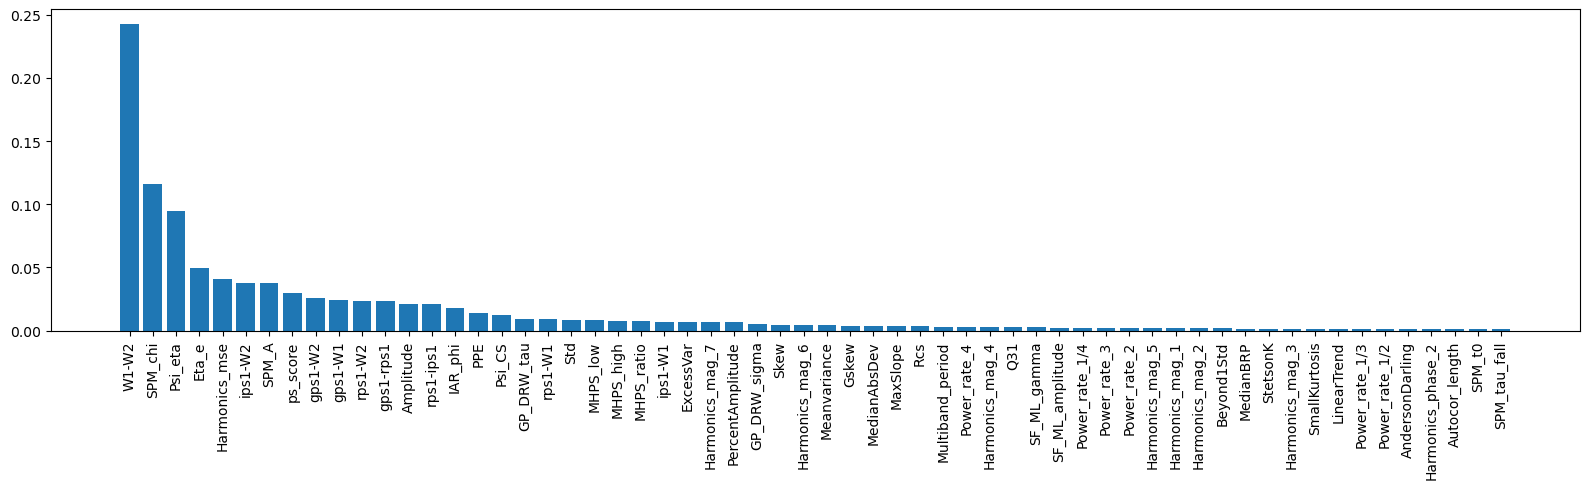

In [24]:
#plotting feature importance
plot_feature_importances(rf_model_variable, features_variable, 'plots/training_feature_ranking_variable_level_'+band+'band_zsep.pdf')


## separating classes (according to the predicted classification):



Counter({'LPV': 6914, 'EB/EW': 6249, 'RRL': 6243, 'EA': 1419, 'YSO': 444, 'Periodic-other': 311, 'DSCT': 156, 'CEP': 108, 'nonvar-star': 47, 'CV/Nova': 12, 'midz-AGN': 8, 'lowz-AGN': 7, 'Blazar': 5, 'SNIa': 1, 'highz-AGN': 1, 'nonvar-galaxy': 1, 'SN-other': 1})


Text(0.5, 1.0, 'sources classified as periodic')

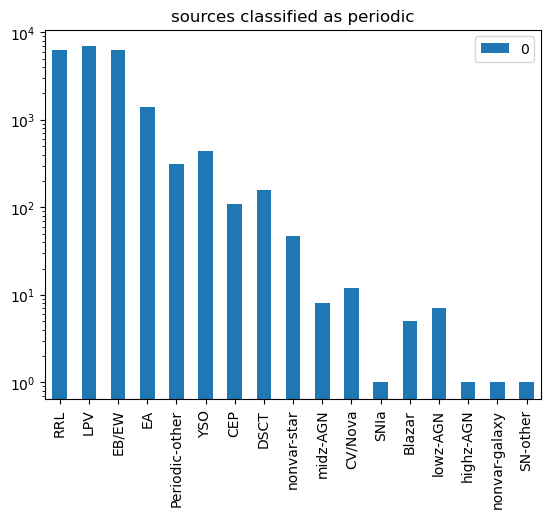

In [25]:
#Periodics

y_test_periodic = y_test_bottom_init.loc[y_pred_variable=='Periodic']
X_test_periodic =  X_test_bottom_init.loc[y_pred_variable=='Periodic',:]

letter_counts = Counter(y_test_periodic)
print(letter_counts)


df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.yscale('log')
plt.title('sources classified as periodic')

Counter({'midz-AGN': 55266, 'lowz-AGN': 4231, 'highz-AGN': 3053, 'YSO': 1645, 'Blazar': 209, 'nonvar-galaxy': 199, 'nonvar-star': 81, 'RRL': 40, 'LPV': 9, 'EB/EW': 6, 'Periodic-other': 6, 'CV/Nova': 4, 'SN-other': 3, 'DSCT': 3, 'EA': 2, 'SNIa': 1})


Text(0.5, 1.0, 'sources classified as stochastic')

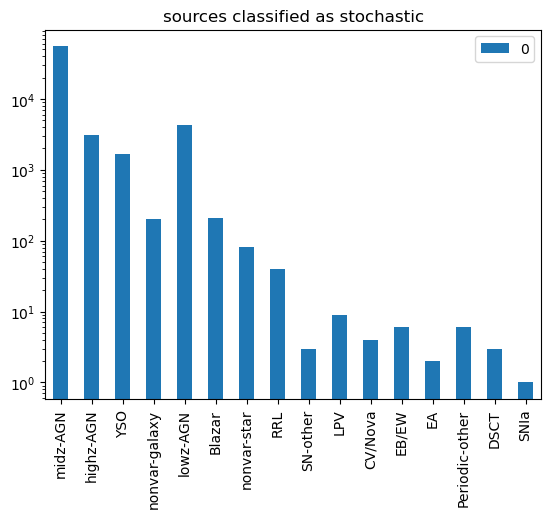

In [26]:
#Stochastics

y_test_stochastic = y_test_bottom_init.loc[y_pred_variable=='Stochastic']
X_test_stochastic =  X_test_bottom_init.loc[y_pred_variable=='Stochastic',:]

letter_counts = Counter(y_test_stochastic)
print(letter_counts)


df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.yscale('log')
plt.title('sources classified as stochastic')

Counter({'CV/Nova': 413, 'midz-AGN': 182, 'SNIa': 169, 'YSO': 128, 'RRL': 114, 'SN-other': 88, 'highz-AGN': 38, 'nonvar-star': 38, 'EA': 23, 'EB/EW': 20, 'lowz-AGN': 20, 'nonvar-galaxy': 19, 'Blazar': 18, 'LPV': 11, 'DSCT': 5, 'Periodic-other': 3})


Text(0.5, 1.0, 'sources classified as transient')

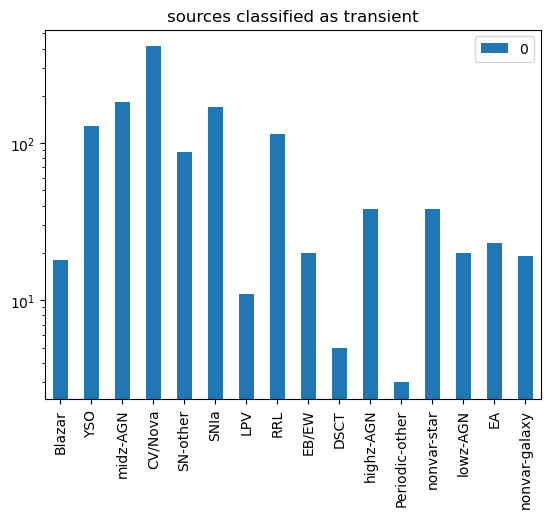

In [27]:
#Transients

y_test_transient = y_test_bottom_init.loc[y_pred_variable=='Transient']
X_test_transient =  X_test_bottom_init.loc[y_pred_variable=='Transient',:]

letter_counts = Counter(y_test_transient)
print(letter_counts)


df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.yscale('log')
plt.title('sources classified as transient')

   ### Periodic model

In [28]:
#Training periodic level

rf_model_periodic = RandomForestClassifier(
            n_estimators=400,
            max_features=0.4,
            max_depth=50,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_periodic.fit(X_train_periodic, y_train_periodic)


#testing periodic layer performance

y_true_periodic, y_pred_periodic = y_test_periodic, rf_model_periodic.predict(X_test_periodic)

y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)

print("Accuracy:", metrics.accuracy_score(y_true_periodic, y_pred_periodic))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true_periodic, y_pred_periodic))

classes_order_proba_periodic = rf_model_periodic.classes_
print(classes_order_proba_periodic)


#Dumping trained model

features_periodic = list(X_train_periodic)

with open(model_periodic_layer, 'wb') as f:
            pickle.dump(
                rf_model_periodic,
                f,
                pickle.HIGHEST_PROTOCOL)

Accuracy: 0.8878551557440598
Balanced accuracy: 0.35502503027168136
['CEP' 'DSCT' 'EA' 'EB/EW' 'LPV' 'Periodic-other' 'RRL']


[[6854    5    1    4    6   39    5]
 [   0 1326   48    5    5   11   24]
 [   0  392 5152  202  135   39  329]
 [   0    4    7  141    2    1    1]
 [   3   29  142   74 5700  223   72]
 [   1    3    1    1    4   86   12]
 [   6   13   34   18   12   19  209]]
Normalized confusion matrix
[[99.  0.  0.  0.  0.  1.  0.]
 [ 0. 93.  3.  0.  0.  1.  2.]
 [ 0.  6. 82.  3.  2.  1.  5.]
 [ 0.  3.  4. 90.  1.  1.  1.]
 [ 0.  0.  2.  1. 91.  4.  1.]
 [ 1.  3.  1.  1.  4. 80. 11.]
 [ 2.  4. 11.  6.  4.  6. 67.]]


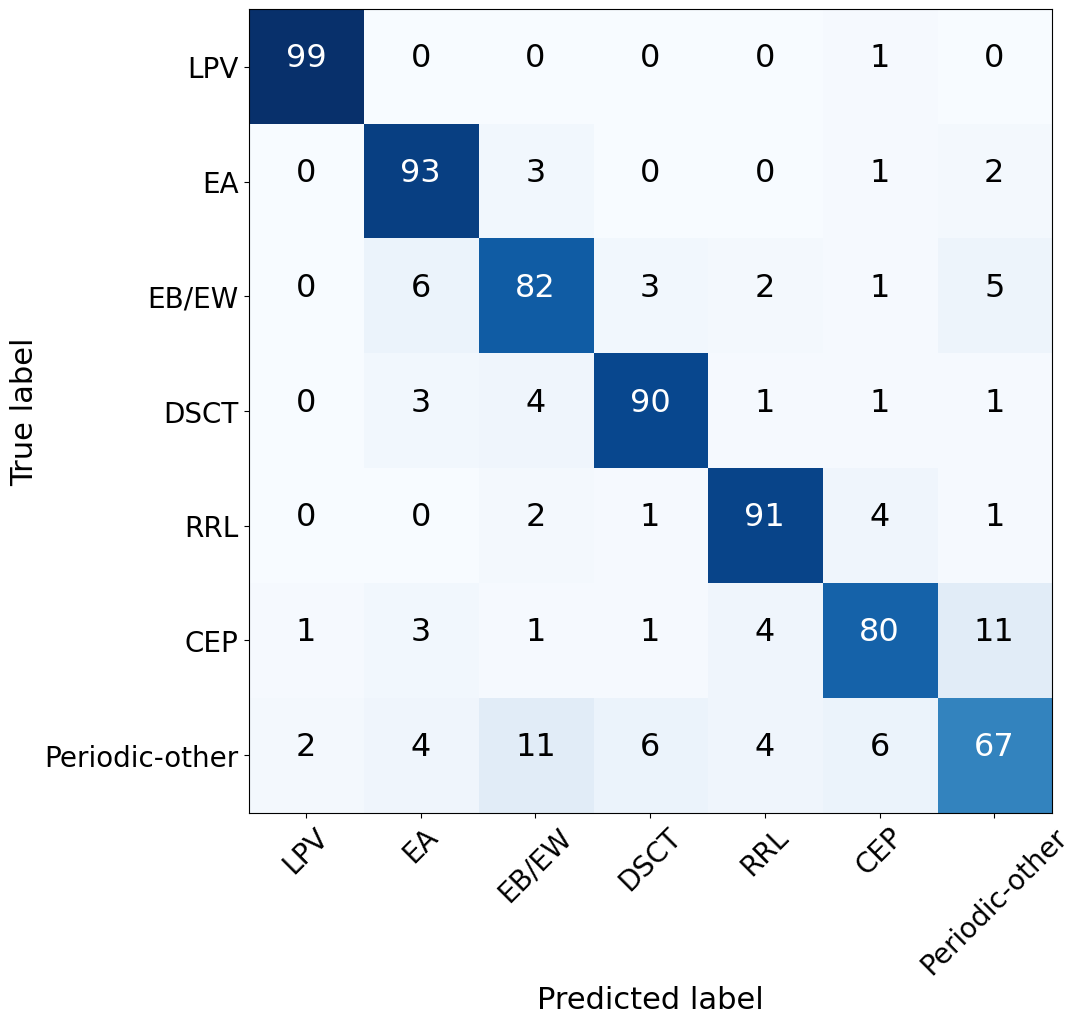

In [29]:
#plotting confusion matrix

cnf_matrix = metrics.confusion_matrix(y_true_periodic, y_pred_periodic, labels=cm_classes_periodic)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_periodic,'plots/training_conf_matrix_periodic_level_'+band+'band_zsep.pdf')

Multiband_period & 0.206
Skew & 0.090
Gskew & 0.062
gps1-W1 & 0.045
GP_DRW_tau & 0.044
gps1-W2 & 0.030
MHPS_ratio & 0.029
IAR_phi & 0.025
Beyond1Std & 0.023
ips1-W1 & 0.021
GP_DRW_sigma & 0.020
rps1-W1 & 0.018
SPM_chi & 0.017
ips1-W2 & 0.017
MedianAbsDev & 0.016
MedianBRP & 0.015
rps1-W2 & 0.013
Meanvariance & 0.013
ExcessVar & 0.012
Q31 & 0.011
Harmonics_mag_1 & 0.011
PPE & 0.010
rps1-ips1 & 0.010
Psi_eta & 0.010
SmallKurtosis & 0.009
Harmonics_phase_2 & 0.009
Std & 0.009
StetsonK & 0.009
SPM_A & 0.008
Amplitude & 0.008


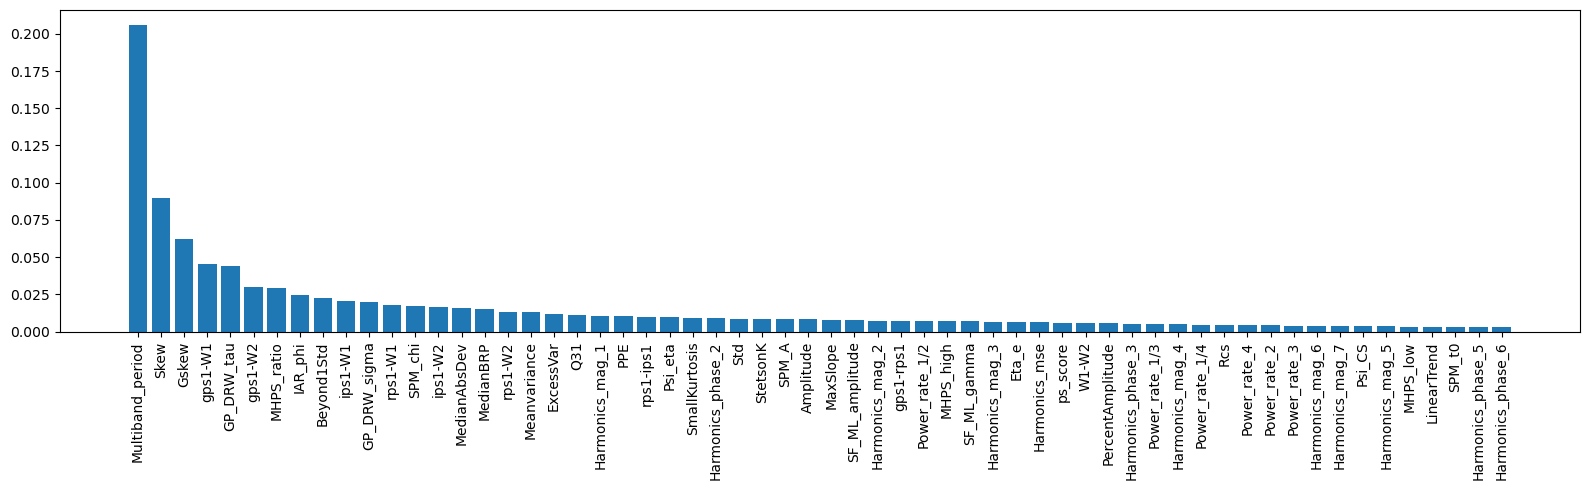

In [30]:
#plotting feature importance
plot_feature_importances(rf_model_periodic, features_periodic, 'plots/training_feature_ranking_periodic_level_'+band+'band_zsep.pdf')



### Stochastic model

In [31]:
#Training stochastic level

rf_model_stochastic = RandomForestClassifier(
            n_estimators=200,
            max_features=0.4,
            max_depth=70,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)


#testing stochastic layer performance

y_true_stochastic, y_pred_stochastic = y_test_stochastic, rf_model_stochastic.predict(X_test_stochastic)

y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)

print("Accuracy:", metrics.accuracy_score(y_true_stochastic, y_pred_stochastic))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true_stochastic, y_pred_stochastic))

classes_order_proba_stochastic = rf_model_stochastic.classes_
print(classes_order_proba_stochastic)


#Dumping trained model

features_stochastic = list(X_train_stochastic)

with open(model_stochastic_layer, 'wb') as f:
            pickle.dump(
                rf_model_stochastic,
                f,
                pickle.HIGHEST_PROTOCOL)

Accuracy: 0.8138917199419377
Balanced accuracy: 0.272371210685617
['Blazar' 'YSO' 'highz-AGN' 'lowz-AGN' 'midz-AGN']


[[ 3417   426    88   292     8]
 [ 3659 44707  5626  1243    31]
 [   14   197  2794    24    24]
 [   10    12     8   177     2]
 [   15     1     1    17  1611]]
Normalized confusion matrix
[[81. 10.  2.  7.  0.]
 [ 7. 81. 10.  2.  0.]
 [ 0.  6. 92.  1.  1.]
 [ 5.  6.  4. 85.  1.]
 [ 1.  0.  0.  1. 98.]]


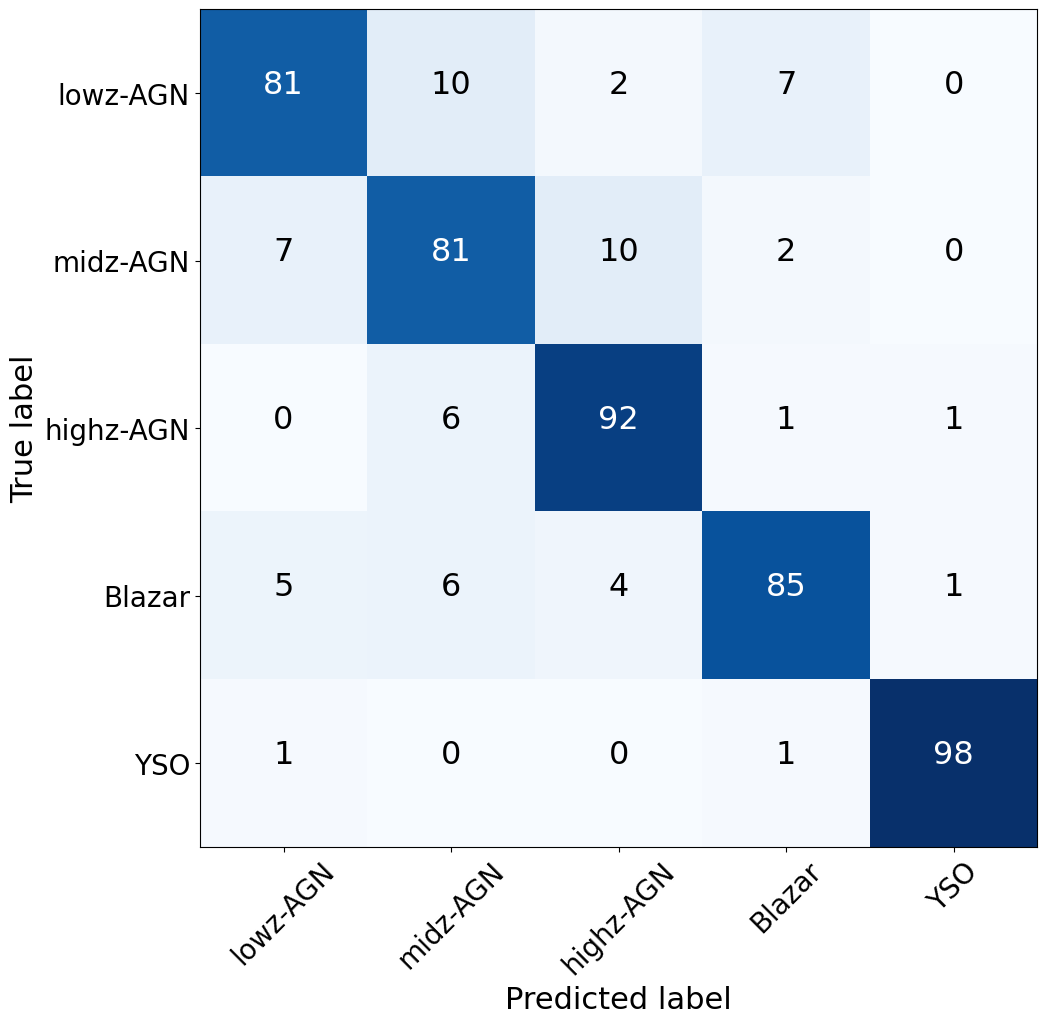

In [32]:
#plotting confusion matrix

cnf_matrix = metrics.confusion_matrix(y_true_stochastic, y_pred_stochastic, labels=cm_classes_stochastic)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_stochastic,'plots/training_conf_matrix_stochastic_level_'+band+'band_zsep.pdf')

W1-W2 & 0.113
rps1-ips1 & 0.105
gps1-rps1 & 0.093
rps1-W1 & 0.075
ps_score & 0.074
SPM_chi & 0.062
rps1-W2 & 0.047
ips1-W1 & 0.043
ips1-W2 & 0.039
gps1-W1 & 0.036
ExcessVar & 0.017
IAR_phi & 0.016
Eta_e & 0.014
Amplitude & 0.013
gps1-W2 & 0.013
SPM_A & 0.010
MedianAbsDev & 0.010
GP_DRW_tau & 0.009
MHPS_low & 0.009
GP_DRW_sigma & 0.009
Q31 & 0.008
Meanvariance & 0.007
Std & 0.007
Harmonics_mse & 0.006
Gskew & 0.006
Psi_eta & 0.006
Rcs & 0.005
MHPS_ratio & 0.005
MaxSlope & 0.005
SF_ML_amplitude & 0.005


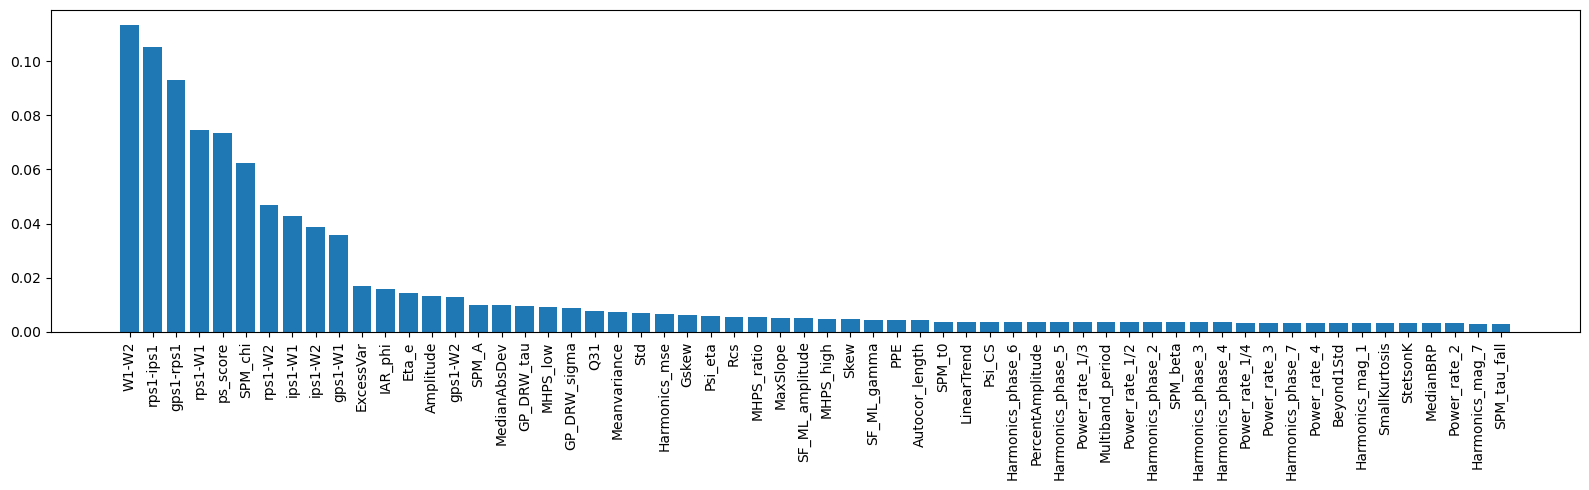

In [33]:
#plotting feature importance
plot_feature_importances(rf_model_stochastic, features_stochastic, 'plots/training_feature_ranking_stochastic_level_'+band+'band_zsep.pdf')



### Transient model

In [34]:
#Training transient level

rf_model_transient = RandomForestClassifier(
            n_estimators=200,
            max_features='auto',
            max_depth=10,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(X_train_transient, y_train_transient)


#testing transient layer performance

y_true_transient, y_pred_transient = y_test_transient, rf_model_transient.predict(X_test_transient)

y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

print("Accuracy:", metrics.accuracy_score(y_true_transient, y_pred_transient))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true_transient, y_pred_transient))

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)


#Dumping trained model

features_transient = list(X_train_transient)

with open(model_transient_layer, 'wb') as f:
            pickle.dump(
                rf_model_transient,
                f,
                pickle.HIGHEST_PROTOCOL)

Accuracy: 0.4724592707525213
Balanced accuracy: 0.15584647588395958
['CV/Nova' 'SN-other' 'SNIa']


[[138  30   1]
 [ 27  60   1]
 [  0   2 411]]
Normalized confusion matrix
[[ 82.  18.   1.]
 [ 31.  68.   1.]
 [  0.   0. 100.]]


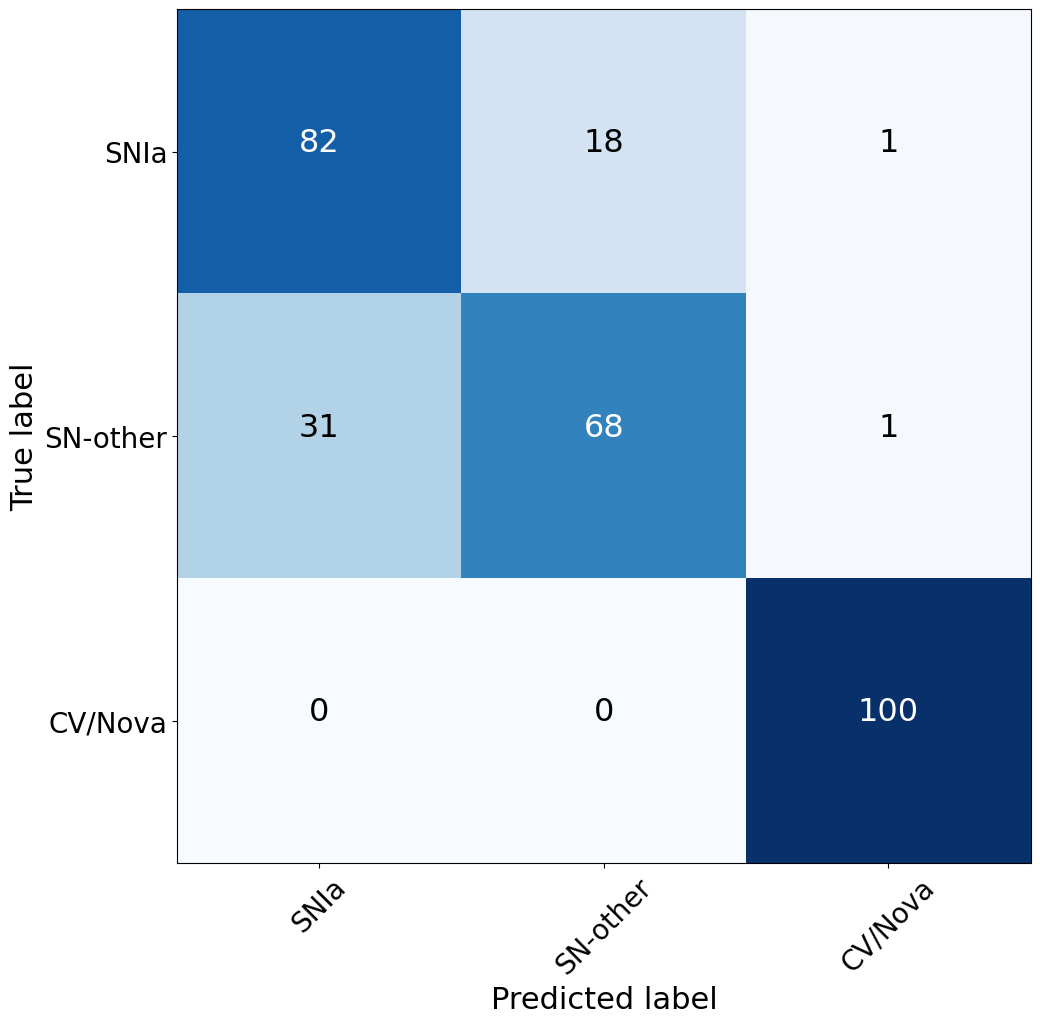

In [35]:
#plotting confusion matrix

cnf_matrix = metrics.confusion_matrix(y_true_transient, y_pred_transient, labels=cm_classes_transient)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_transient,'plots/training_conf_matrix_transient_level_'+band+'band_zsep.pdf')

ps_score & 0.194
rps1-W1 & 0.042
ips1-W1 & 0.040
MHPS_high & 0.037
rps1-ips1 & 0.036
gps1-rps1 & 0.036
ips1-W2 & 0.034
gps1-W1 & 0.034
rps1-W2 & 0.026
SPM_A & 0.025
gps1-W2 & 0.025
SPM_tau_fall & 0.023
SPM_chi & 0.021
PercentAmplitude & 0.020
Harmonics_mse & 0.017
Skew & 0.016
Eta_e & 0.014
GP_DRW_tau & 0.013
GP_DRW_sigma & 0.012
ExcessVar & 0.012
MHPS_ratio & 0.012
Gskew & 0.011
Meanvariance & 0.011
SPM_tau_rise & 0.011
Q31 & 0.011
PPE & 0.011
MedianAbsDev & 0.011
Amplitude & 0.010
W1-W2 & 0.010
IAR_phi & 0.010


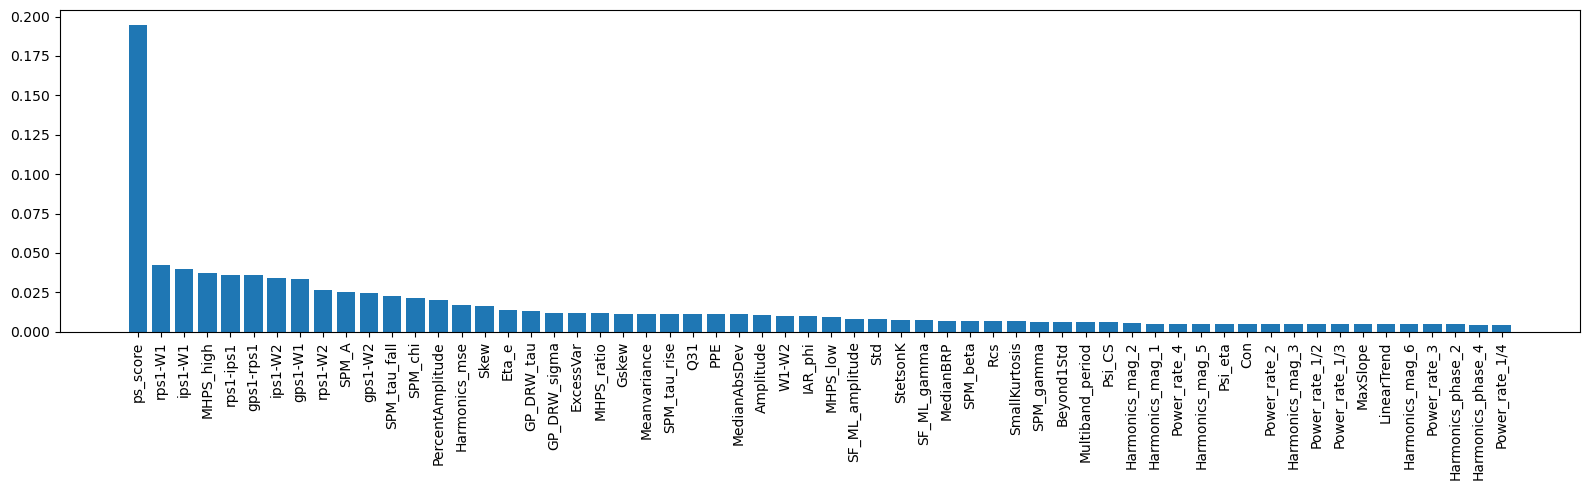

In [36]:
#plotting feature importance
plot_feature_importances(rf_model_transient, features_transient, 'plots/training_feature_ranking_transient_level_zsep.pdf')



## Putting all together 

[[  138    30     1     1     0     0     0     0     1     0     0     0
      0     0     0   214     1]
 [   27    60     1     2     0     0     1     0     1     0     0     0
      0     0     0    94     0]
 [    0     2   411     0     0     2     0     2     1     1     0     2
      2     2     4     4     9]
 [    9    10     1  3417   426    88   292     8     3     0     0     0
      1     3     0  2440    10]
 [    5    36   141  3659 44707  5626  1243    31     1     0     0     1
      2     2     2   348   116]
 [    1     4    33    14   197  2794    24    24     0     0     0     0
      0     0     1    25    32]
 [    3     1    14    10    12     8   177     2     4     0     0     0
      0     1     0    87     3]
 [    8    17   103    15     1     1    17  1611    90    58     5    43
     21    43   184    55   372]
 [    1     6     4     0     0     0     0     9  6854     5     1     4
      6    39     5     1     8]
 [    0     0    23     0     0     0

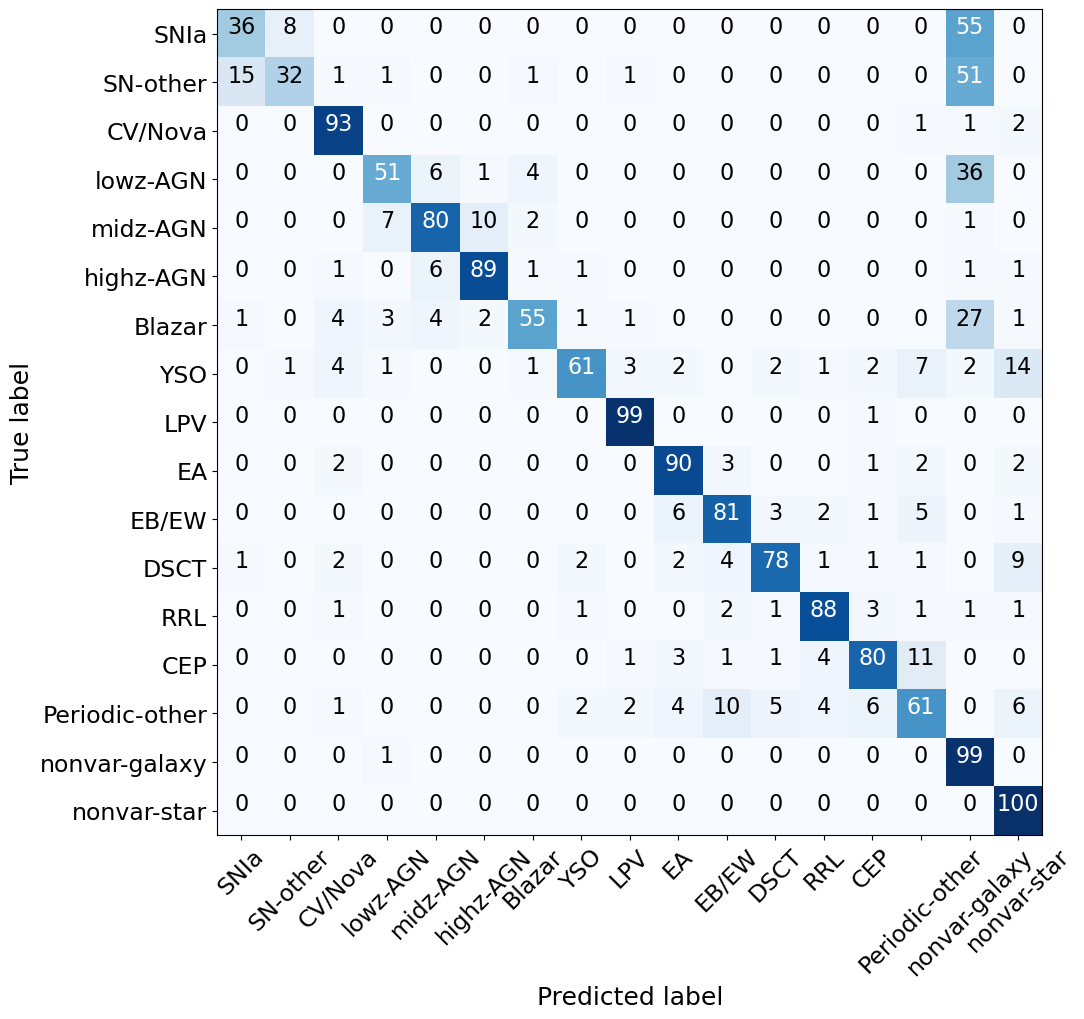

In [37]:
# generating confusion matrix for multilabels



y_true_bottom = np.concatenate((y_true_stochastic,y_true_periodic,y_true_transient,y_test_bottom.loc[y_pred!='variable']))
y_pred_bottom = np.concatenate((y_pred_stochastic,y_pred_periodic,y_pred_transient,y_pred[np.where(y_pred!='variable')]))

cnf_matrix = metrics.confusion_matrix(y_true_bottom, y_pred_bottom,labels=cm_classes_original)
print(cnf_matrix)
plot_confusion_matrix_all(cnf_matrix,cm_classes_original, 'plots/training_conf_matrix_bottom_level_'+band+'band_zsep.pdf')

print("Accuracy:", metrics.accuracy_score(y_true_bottom, y_pred_bottom))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true_bottom, y_pred_bottom))

In [38]:
print(metrics.classification_report(y_true_bottom, y_pred_bottom, target_names=np.unique(y_true_bottom)))

                precision    recall  f1-score   support

        Blazar       0.10      0.55      0.17       322
           CEP       0.18      0.80      0.30       108
       CV/Nova       0.46      0.93      0.62       442
          DSCT       0.28      0.78      0.42       180
            EA       0.72      0.90      0.80      1480
         EB/EW       0.96      0.81      0.88      6341
           LPV       0.98      0.99      0.99      6943
Periodic-other       0.24      0.61      0.34       342
           RRL       0.97      0.88      0.92      6506
      SN-other       0.31      0.32      0.32       186
          SNIa       0.68      0.36      0.47       386
           YSO       0.90      0.61      0.73      2644
     highz-AGN       0.33      0.89      0.48      3149
      lowz-AGN       0.47      0.51      0.49      6708
      midz-AGN       0.99      0.80      0.88     55920
 nonvar-galaxy       0.86      0.99      0.92     20436
   nonvar-star       0.99      1.00      0.99  

In [39]:
np.unique(y_true_bottom)

array(['Blazar', 'CEP', 'CV/Nova', 'DSCT', 'EA', 'EB/EW', 'LPV',
       'Periodic-other', 'RRL', 'SN-other', 'SNIa', 'YSO', 'highz-AGN',
       'lowz-AGN', 'midz-AGN', 'nonvar-galaxy', 'nonvar-star'],
      dtype=object)

In [40]:
print(metrics.classification_report(y_true_bottom, y_pred_bottom,labels=cm_classes_original))

                precision    recall  f1-score   support

          SNIa       0.68      0.36      0.47       386
      SN-other       0.31      0.32      0.32       186
       CV/Nova       0.46      0.93      0.62       442
      lowz-AGN       0.47      0.51      0.49      6708
      midz-AGN       0.99      0.80      0.88     55920
     highz-AGN       0.33      0.89      0.48      3149
        Blazar       0.10      0.55      0.17       322
           YSO       0.90      0.61      0.73      2644
           LPV       0.98      0.99      0.99      6943
            EA       0.72      0.90      0.80      1480
         EB/EW       0.96      0.81      0.88      6341
          DSCT       0.28      0.78      0.42       180
           RRL       0.97      0.88      0.92      6506
           CEP       0.18      0.80      0.30       108
Periodic-other       0.24      0.61      0.34       342
 nonvar-galaxy       0.86      0.99      0.92     20436
   nonvar-star       0.99      1.00      0.99  